<div>
   <a href="https://colab.research.google.com/drive/1WRKiQPUeFDuYBZo2PXFLntirsQ_JJsYY?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Outline

This tutorial introduces the application of the module `batch_processing` in analyzing a large amount of audio recordings.
Please contact Yi-Jen Sun (elainesun442@gmail.com) or Tzu-Hao Harry Lin (schonkopf@gmail.com) for questions or suggestions.

<img src="https://raw.githubusercontent.com/yijensun/soundscape_IR/master/docs/images/batch_wf_v3.png" width="500" hspace="20"/>

This figure shows various applications of soundscape information retrieval supported by using the module `batch_processing`. This tutorial contains three sections:
1. Generating a concatenated spectrogram from multiple recordings
2. Applying model-based source separation to detect target sounds
3. Performing adaptive and semi-supervised source separation to assess acoustic diversity


# Installation

In [ ]:
# Clone soundscape_IR toolbox
!git clone https://github.com/meil-brcas-org/soundscape_IR.git

# Install required packages
%cd soundscape_IR
%pip install -r requirements.txt
%pip install umap-learn

# Spectrogram concatenation



In order to build a robust source separation model, we often need to use a large amount of annotated sounds for model training. The module `batch_processing` allows to extract annotated clips from multiple recordings and subsequently generates a concatenated spectrogram. 

At first, create a folder and copy a set of annotated recordings to the folder. Enter the folder path in `folder` and the extended file name of the associated txt files containing annotations (generated by using [Raven software](https://ravensoundsoftware.com/)) in `annotation_extension`. For example, if our recording files are named using the structure of __Location_Date_Time.wav__ and txt files are __Location_Date_Time.Table.1.selections.txt__, please enter `annotation_extension='.Table.1.selections.txt'`.

Then, define spectrogram parameters and set `folder_combine=True` in `batch_processing.params_spectrogram`. By doing this, `batch_processing` will combine all the recordings from the folder and generate a concatenated spectrogram according to the associated annotations. If only a portion of recordings in the folder is needed, we can specify the beginning file number (start from 1) in `start` and the number of recordings in `num_file`.

After performing `batch_processing`, a concatenated spectrogram is saved in `batch_processing.spectrogram`, and we can plot the concatenated spectrogram by using `matrix_operation().plot_lts`.








Identified  4 files
Processing file no. 2 :batch_2.wav, in total: 2 files

C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\soundscape_IR\soundscape_viewer\source_separation.py:111: RuntimeWarning: invalid value encountered in true_divide
  mask=np.divide(source,source0)


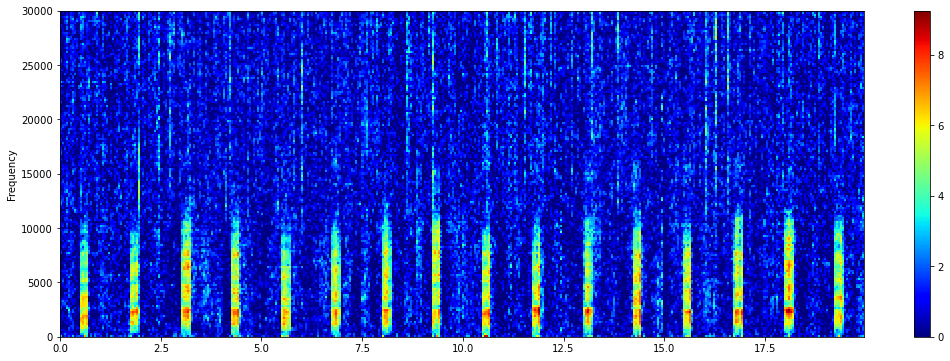

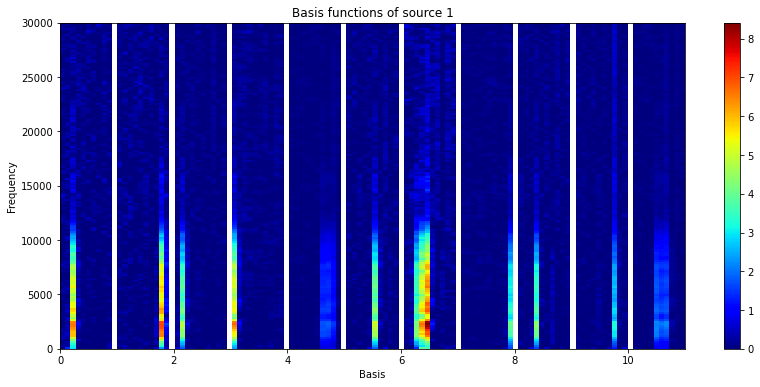

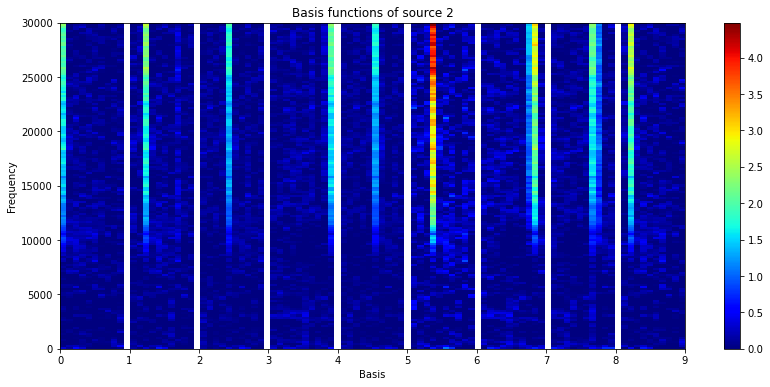

In [2]:
from soundscape_IR.soundscape_viewer import batch_processing
from soundscape_IR.soundscape_viewer import matrix_operation
from soundscape_IR.soundscape_viewer import source_separation

# Assign the folder path contains annotated recordings
path='./data/batch/sec1_2/'

# Define parameters
batch = batch_processing(folder=path, file_extension='.wav', annotation_extension='.Table.1.selections.txt')
batch.params_spectrogram(FFT_size=1024, f_range = [0,30000], environment='wat', prewhiten_percent=20, time_resolution=0.05, padding=0.5, folder_combine=True)
batch.run(start=1, num_file=2)

# Plot concatenated spectrogram
matrix_operation().plot_lts(batch.spectrogram, batch.f, fig_width=18, fig_height=6, lts=False)

# Train a source separation model using PC-NMF
model=source_separation(feature_length=10, basis_num=20)
model.learn_feature(input_data=batch.spectrogram, f=batch.f, method='PCNMF')

# Plot the basis functions of each source
model.plot_nmf(plot_type='W', source=1)
model.plot_nmf(plot_type='W', source=2)

# Source separation and spectrogram detection

This section demonstrates the use of a source separation model in `batch_processing` to detect target sounds from a set of unannotated recordings. 

Here, we set `folder_combine=False` to sequentially process recordings. In addition, we add `batch_processing.params_separation` and `batch_processing.params_spectrogram_detection` to import the model and to run an energy detector. In `batch_processing.params_spectrogram_detection`, we can specify multiple sources (e.g., `source=[1,2]`) to separately detect regions of interests from different sources.

Detection results will be saved as txt files (with source number after the original filename), using the same annotation format prepared via Raven software. The plotting function of detection results can be deactivated by setting `show_result=False`.



Identified  4 files
Processing file no. 4 :batch_4.wav, in total: 2 files

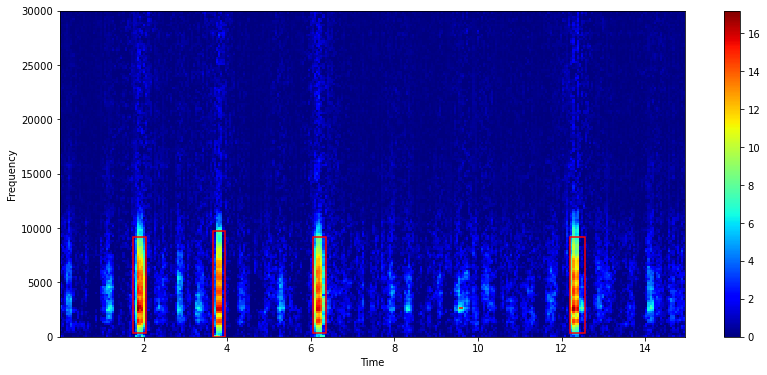

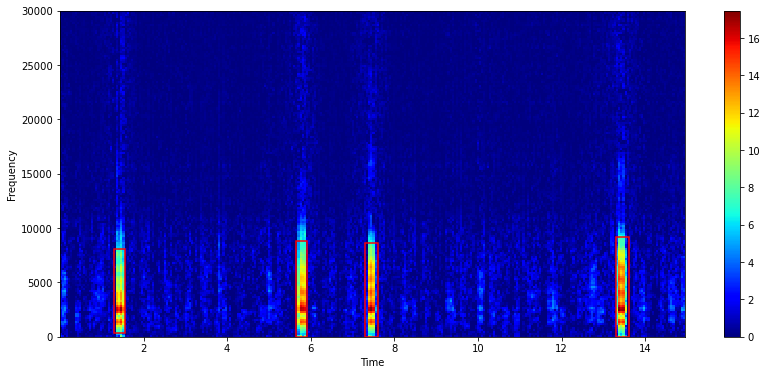

In [3]:
from soundscape_IR.soundscape_viewer import batch_processing

# Assign the folder path of unannotated recordings and the path for saving detection results (in txt format)
path='./data/batch/sec1_2/'
save_path = './data/txt'

# Define parameters
batch = batch_processing(folder=path, file_extension='.wav')
batch.params_spectrogram(FFT_size=1024, environment='wat', prewhiten_percent=20, time_resolution=0.05, f_range=[0, 30000])
batch.params_separation(model)
batch.params_spectrogram_detection(source=1, threshold=6, smooth=1, pad_size=0, path=save_path, minimum_interval=0.5, show_result=True)
batch.run(start=3, num_file=2)

# Adaptive and semi-supervised source separation

The application of source separation in `batch_processing` also enables the use of adpated and semi-supervised learning methods in extracting acoustic features associated with target sounds displaying varied features and unknown sounds.

At first, load a source separation model previously trained. Then, define `adaptive_alpha` and `additional_basis` in `batch_processing.params_separation` to enable adpated and semi-supervised source separation. Note that we can assign multiple values in `adaptive_alpha`  for different sound sources. In this example, we allow basis functions associated with deer calls to adapt from the variations among different calling individuals.

In `batch_processing.params_separation`, set `save_basis=True` to save the basis fuctions learned in source separation procedures into a mat file.

Model parameters check
Minima and maxima frequancy bin: 0.0 Hz and 7924.21875 Hz
Frequancy resolution: 86.1328125 Hz
Feature length: 24
Number of basis: 10
Number of source: 2
Identified  12 files
Processing file no. 12 :KT08_20171118_134500.wav, in total: 12 files

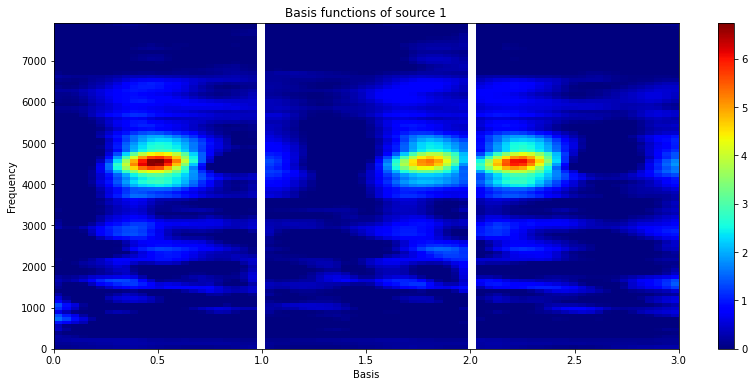

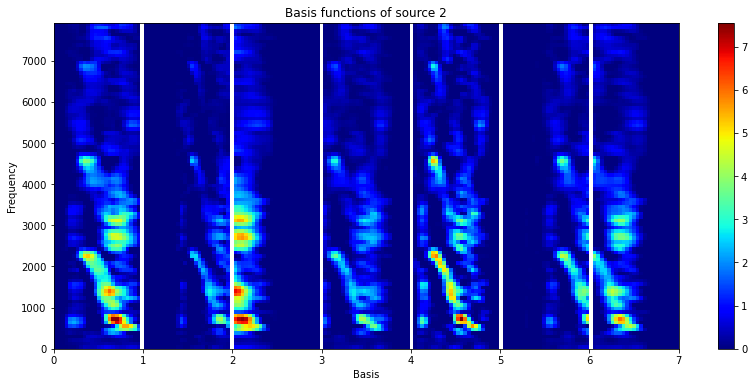

In [4]:
from soundscape_IR.soundscape_viewer import source_separation
from soundscape_IR.soundscape_viewer import batch_processing

# Load a source separation model
model=source_separation()
model.load_model('./data/model/KT08_linear_fl24_bn10.mat')

# Assign the folder_id of unannotated recordings and the path for saving basis functions (in mat format)
path='./data/batch/sec3/'
save_path='./data/mat'

# Define parameters
batch = batch_processing(folder=path, file_extension='.wav')
batch.params_spectrogram(FFT_size=512, time_resolution=0.1, window_overlap=0.5, prewhiten_percent=25, f_range=[0,8000])
batch.params_separation(model, adaptive_alpha=[0,0.2], additional_basis = 0, save_basis=True, path=save_path)
batch.run()

# Load the basis functions from a specific mat file
load_basis=source_separation()
load_basis.load_model('./data/mat/KT08_20171118_123000.mat', model_check=False)

# Plot the basis functions of each source
for i in range(load_basis.source_num):
  load_basis.plot_nmf(plot_type = 'W', source = i+1)

Aftering performing adapted or semi-supervised source separation, we can use `batch_processing` to load all basis functions for visualizing acoustic diversity. 

Here, we use `batch_processing.params_load_result` to load a large number of mat files. Please enter the filename information of the mat files so that `batch_processing` can extract the recording date and time from each mat file. For example, if the file name is 'KT08_20171118_123000.mat', please enter `initial='KT08_'` and `dateformat='yyyymmdd_HHMMSS'`. After the loading procedure, a source separation model contains all the basis functions is saved in `batch_processing.model`, and we can use `model.plot_nmf()` to plot basis functions or extract basis functions from `model.W` and `model.W_cluster`.

Identified  12 files
Processing file no. 1 :KT08_20171118_110000.mat, in total: 12 filesExample:  KT08_20171118_110000.mat
Please review whether the date and time are retrieved correctly.
Year: 2017
Month: 11
Day: 18
Hour: 11
Minute: 00
Second: 00
Processing file no. 12 :KT08_20171118_134500.mat, in total: 12 files

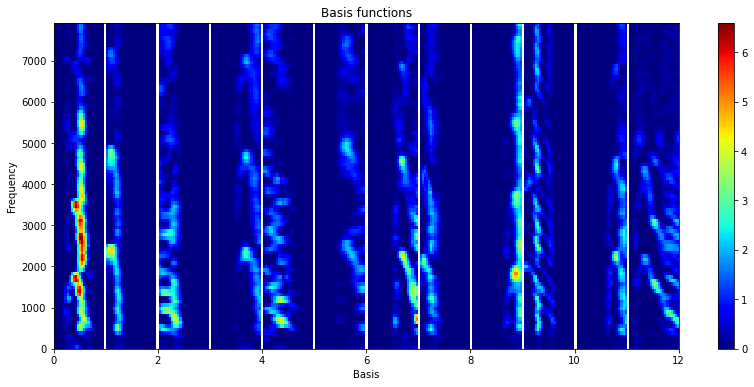

In [5]:
from soundscape_IR.soundscape_viewer import batch_processing

# Assign the folder path of saved mat files
mat_path='./data/mat'

# Define parameters
batch = batch_processing(folder=mat_path, file_extension='.mat')
batch.params_load_result(data_type='basis', initial='KT08_', dateformat='yyyymmdd_HHMMSS')
batch.run()

# Plot the entire set of basis functions
idx = batch.model.W_cluster == 1
batch.model.W = batch.model.W[:,idx][:,::7]
batch.model.plot_nmf(plot_type='W')

With adapted source separation, we can obtain a set of basis functions associated with different sound types. We choose one feature from the adapted basis functions in each mat file and project these basis functions on an one-dimensional axis using Uniform Manifold Approximation and Projection (UMAP). The UMAP coordinate summarizes the spectral variations of the adapted basis functions. By sorting the adapted basis functions according to their UMAP scores, the basis functions at the left part are mostly characterized by burst-pulses, and the basis functions at the right part are tonal sounds with a few harmonics.

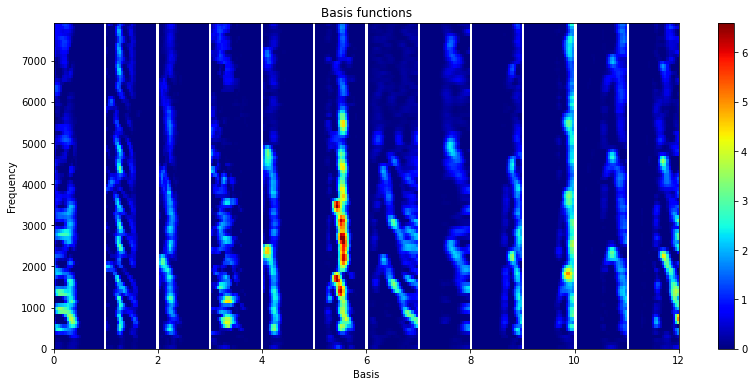

In [20]:
import umap
import numpy as np

# Performing UMAP analysis on the adapted basis functions
model = umap.UMAP(n_neighbors=3, n_components = 1)
data_umap = model.fit_transform(batch.model.W.T)

# Display the spectral variations of the adapted basis functions
idx = np.argsort(data_umap[:,0])
batch.model.W = batch.model.W[:,idx]
batch.model.plot_nmf(plot_type='W')